In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import torchvision.transforms
import random
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
from documents.load_data import *
from Model.RNN_LSTM import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_loader, test_loader, val_loader, _ = loader()(subject = 1,
                                             batch_size= 30,
                                             num_validation =37)

Train data shape:  (200, 22, 1000)
Train labels shape:  (200,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (37, 22, 1000)
Validation labels shape:  (37,)


In [3]:
criteria = F.cross_entropy

def train(epoch,device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(test_loader=test_loader, mode = 'val',device=None):
    # train mode to get the train accuracy 
    # val mode to get the validation accuracy
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += criteria(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        
    test_loss /= len(test_loader.dataset)
    if mode == 'train':
        print('train loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

    else:
        print('validation loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return [test_loss,correct / len(test_loader.dataset)]

In [4]:
def main_train(epoches = 8):
    stats = {}
    stats['train'] = []
    stats['val']  = []
    
    device = torch.device("cuda")

    epoches = range(epoches)
    for epoch in epoches:
        train(epoch,device)
        stats['train'].append(test(train_loader, mode='train',device=device))
        stats['val'].append(test(val_loader, mode='val',device=device))

    print('Test set result:')
    test(test_loader, mode = 'val',device=device)

    stats['val']  = np.array(stats['val'])
    stats['train'] = np.array(stats['train'])

    fig, ax = plt.subplots(1, 2,figsize = (8,4))
    ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

    ax[0].legend(['validation','train'])
    ax[0].set_title('loss')

    ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

    ax[1].legend(['validation','train'])
    ax[1].set_title('accuracy')

Train data shape:  (199, 22, 1000)
Train labels shape:  (199,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 0 [0/199 (0%)]	Loss: 1.388113
Train Epoch: 0 [150/199 (71%)]	Loss: 1.380879
train loss: 1.3838, Accuracy: 66/199 (33%)
validation loss: 1.3850, Accuracy: 12/38 (32%)

Train Epoch: 1 [0/199 (0%)]	Loss: 1.369714
Train Epoch: 1 [150/199 (71%)]	Loss: 1.371291
train loss: 1.3676, Accuracy: 87/199 (44%)
validation loss: 1.3791, Accuracy: 15/38 (39%)

Train Epoch: 2 [0/199 (0%)]	Loss: 1.347768
Train Epoch: 2 [150/199 (71%)]	Loss: 1.302856
train loss: 1.3228, Accuracy: 91/199 (46%)
validation loss: 1.3566, Accuracy: 16/38 (42%)

Train Epoch: 3 [0/199 (0%)]	Loss: 1.326967
Train Epoch: 3 [150/199 (71%)]	Loss: 1.255037
train loss: 1.2283, Accuracy: 93/199 (47%)
validation loss: 1.2896, Accuracy: 14/38 (37%)

Train Epoch: 4 [0/199 (0%)]	Loss: 1.204755
Train Epoch: 4 [150/199 (71%)]	Loss: 1.21793

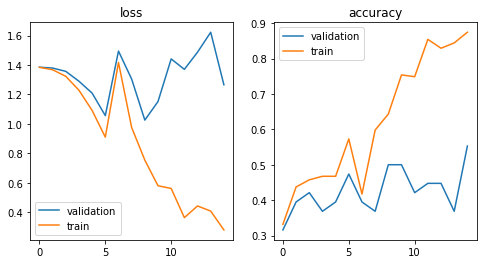

In [39]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= 1,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = RNN_LSTM(
    input_size=100,
    hidden_size=100,
    num_layers=2,
    num_classes=4,
    bidirectional=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 15)

Train data shape:  (198, 22, 1000)
Train labels shape:  (198,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 0 [0/198 (0%)]	Loss: 1.396714
Train Epoch: 0 [150/198 (71%)]	Loss: 1.398283
train loss: 1.3854, Accuracy: 48/198 (24%)
validation loss: 1.3874, Accuracy: 9/38 (24%)

Train Epoch: 1 [0/198 (0%)]	Loss: 1.391426
Train Epoch: 1 [150/198 (71%)]	Loss: 1.371297
train loss: 1.3750, Accuracy: 78/198 (39%)
validation loss: 1.3828, Accuracy: 14/38 (37%)

Train Epoch: 2 [0/198 (0%)]	Loss: 1.348854
Train Epoch: 2 [150/198 (71%)]	Loss: 1.369596
train loss: 1.3577, Accuracy: 83/198 (42%)
validation loss: 1.3750, Accuracy: 14/38 (37%)

Train Epoch: 3 [0/198 (0%)]	Loss: 1.348076
Train Epoch: 3 [150/198 (71%)]	Loss: 1.334746
train loss: 1.3331, Accuracy: 93/198 (47%)
validation loss: 1.3662, Accuracy: 12/38 (32%)

Train Epoch: 4 [0/198 (0%)]	Loss: 1.321239
Train Epoch: 4 [150/198 (71%)]	Loss: 1.299385

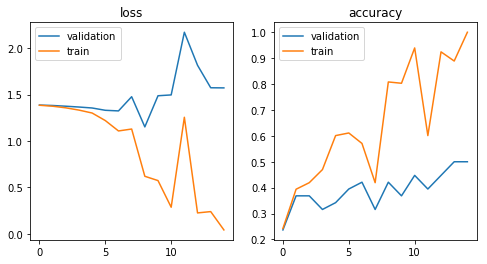

In [50]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= 2,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = RNN_LSTM(
    input_size=100,
    hidden_size=100,
    num_layers=2,
    num_classes=4,
    bidirectional=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0006, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 15)

Train data shape:  (198, 22, 1000)
Train labels shape:  (198,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 0 [0/198 (0%)]	Loss: 1.405683
Train Epoch: 0 [150/198 (71%)]	Loss: 1.389966
train loss: 1.3845, Accuracy: 53/198 (27%)
validation loss: 1.3858, Accuracy: 10/38 (26%)

Train Epoch: 1 [0/198 (0%)]	Loss: 1.383282
Train Epoch: 1 [150/198 (71%)]	Loss: 1.376398
train loss: 1.3757, Accuracy: 53/198 (27%)
validation loss: 1.3848, Accuracy: 10/38 (26%)

Train Epoch: 2 [0/198 (0%)]	Loss: 1.366410
Train Epoch: 2 [150/198 (71%)]	Loss: 1.358637
train loss: 1.3587, Accuracy: 67/198 (34%)
validation loss: 1.3864, Accuracy: 10/38 (26%)

Train Epoch: 3 [0/198 (0%)]	Loss: 1.360881
Train Epoch: 3 [150/198 (71%)]	Loss: 1.336009
train loss: 1.3336, Accuracy: 105/198 (53%)
validation loss: 1.3856, Accuracy: 13/38 (34%)

Train Epoch: 4 [0/198 (0%)]	Loss: 1.340762
Train Epoch: 4 [150/198 (71%)]	Loss: 1.3061

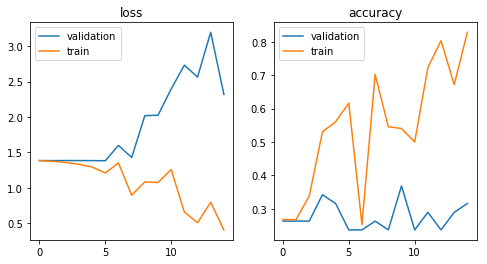

In [64]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= 3,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = RNN_LSTM(
    input_size=100,
    hidden_size=100,
    num_layers=2,
    num_classes=4,
    bidirectional=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0006, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 15)

Train data shape:  (196, 22, 1000)
Train labels shape:  (196,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 0 [0/196 (0%)]	Loss: 1.382554
Train Epoch: 0 [150/196 (71%)]	Loss: 1.387950
train loss: 1.3832, Accuracy: 55/196 (28%)
validation loss: 1.3850, Accuracy: 11/38 (29%)

Train Epoch: 1 [0/196 (0%)]	Loss: 1.383889
Train Epoch: 1 [150/196 (71%)]	Loss: 1.366020
train loss: 1.3755, Accuracy: 55/196 (28%)
validation loss: 1.3821, Accuracy: 11/38 (29%)

Train Epoch: 2 [0/196 (0%)]	Loss: 1.368265
Train Epoch: 2 [150/196 (71%)]	Loss: 1.344446
train loss: 1.3635, Accuracy: 65/196 (33%)
validation loss: 1.3798, Accuracy: 12/38 (32%)

Train Epoch: 3 [0/196 (0%)]	Loss: 1.351221
Train Epoch: 3 [150/196 (71%)]	Loss: 1.370412
train loss: 1.3448, Accuracy: 77/196 (39%)
validation loss: 1.3711, Accuracy: 13/38 (34%)

Train Epoch: 4 [0/196 (0%)]	Loss: 1.332508
Train Epoch: 4 [150/196 (71%)]	Loss: 1.35688

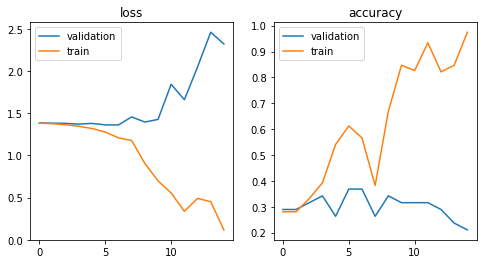

In [61]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= 4,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = RNN_LSTM(
    input_size=100,
    hidden_size=100,
    num_layers=2,
    num_classes=4,
    bidirectional=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 15)

Train data shape:  (197, 22, 1000)
Train labels shape:  (197,)
test data shape:  (47, 22, 1000)
test labels shape:  (47,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 0 [0/197 (0%)]	Loss: 1.388641
Train Epoch: 0 [150/197 (71%)]	Loss: 1.397011
train loss: 1.3856, Accuracy: 50/197 (25%)
validation loss: 1.3859, Accuracy: 10/38 (26%)

Train Epoch: 1 [0/197 (0%)]	Loss: 1.386635
Train Epoch: 1 [150/197 (71%)]	Loss: 1.383858
train loss: 1.3803, Accuracy: 55/197 (28%)
validation loss: 1.3850, Accuracy: 11/38 (29%)

Train Epoch: 2 [0/197 (0%)]	Loss: 1.372106
Train Epoch: 2 [150/197 (71%)]	Loss: 1.367731
train loss: 1.3712, Accuracy: 82/197 (42%)
validation loss: 1.3837, Accuracy: 13/38 (34%)

Train Epoch: 3 [0/197 (0%)]	Loss: 1.370651
Train Epoch: 3 [150/197 (71%)]	Loss: 1.364164
train loss: 1.3589, Accuracy: 107/197 (54%)
validation loss: 1.3830, Accuracy: 10/38 (26%)

Train Epoch: 4 [0/197 (0%)]	Loss: 1.365720
Train Epoch: 4 [150/197 (71%)]	Loss: 1.3472

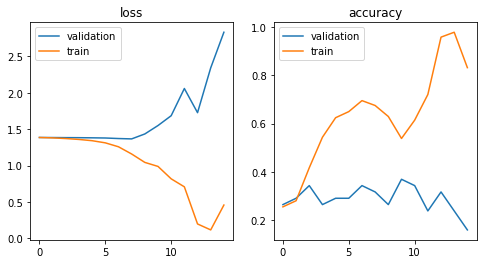

In [65]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= 5,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = RNN_LSTM(
    input_size=100,
    hidden_size=100,
    num_layers=2,
    num_classes=4,
    bidirectional=True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 15)

In [ ]:
device = torch.device("cuda")
train_loader, test_loader, val_loader, test_loaders = loader()(subject = "ALL",
                                                            batch_size = 30,
                                                            num_validation = 37)
print('-'*20)
for batch_idx, (data, target) in enumerate(train_loader):
    print('data size:',data.shape)
    break
model = RNN_LSTM(
    input_size=22,
    hidden_size=200,
    num_layers=2,
    num_classes=4,
    bidirectional=False
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 20)
for i in range(9):
    print('This is test set result for subject{}:'.format(i+1))
    test(test_loaders[i], mode = 'val',device=device)

Train data shape:  (1782, 22, 1000)
Train labels shape:  (1782,)
test data shape:  (443, 22, 1000)
test labels shape:  (443,)
Validation data shape:  (333, 22, 1000)
Validation labels shape:  (333,)
